# 인물 사진을 만들어 봅시다.

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

### 이미지를 가져옵니다.

(1246, 935, 3)


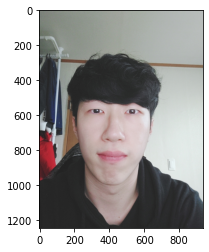

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_picture_1.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 사전 학습된 모델을 가져옵니다.
* 저장할 url과 파일 이름을 결정한 후 제공된 url의 모델을 내 파일로 가져옵니다.

In [3]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fc734505370>)

In [4]:
#가져온 모델을 불러옵니다.
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

### 모델에게 이미지를 입력해줍니다.
* 모델은 이미지를 클래스 별로 분류합니다.
* 배경을 제외하고 20가지의 클래스로 분류해줍니다.

In [5]:
segment,output = model.segmentAsPascalvoc(img_path)

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

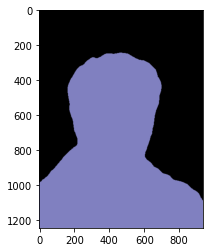

In [7]:
plt.imshow(output)
plt.show()

### 이미지가 어떻게 분류되었는지 확인합니다.
* 그리고 분류된 클래스별 색상을 확인해봅시다.

In [10]:
segment
for name in segment['class_ids']:
    print(LABEL_NAMES[name]+" ",end='')

background person 

In [15]:
# 클래스별 색상입니다.
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

* 배열 자체에 bitshift가 가능한지 의문이 들었는데 그냥 배열 전체 요소를 shift하는 것이었습니다.
* 오른쪽 shift는 1칸당 2로 나누어 주는것과 같으므로 >>3은 2^3으로 나누는 것과 동일합니다.

In [16]:
for name in segment['class_ids']:
    print("{}의 색상 정보 : {}".format(LABEL_NAMES[name],colormap[name]))

background의 색상 정보 : [0 0 0]
person의 색상 정보 : [192 128 128]


* 찾아낸 class의 색상정보입니다. 단 RGB 순서로 배치가 되어있는데 output은 BGR 순서로 배치되어 있습니다.
* 따라서 아래와 같이 색상정보를 재배열합니다.

In [26]:
#색상 정보를 뒤집어줍니다.
seg_color = np.flip(colormap[15])
seg_color

array([128, 128, 192])

(1246, 935)


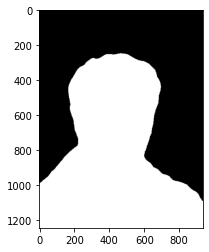

In [27]:
#output과 person의 색상정보를 대조 후 결과로 초기화
#같다면 1,다르다면 0
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

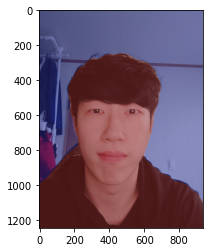

In [28]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 이미지를 블러처리 합니다.
* 이미지를 블러처리 후 person의 class 영역을 지워봅시다.

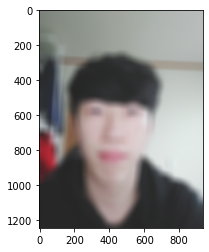

In [29]:
#cv의 blur 함수로 이미지를 블러처리합니다.
img_orig_blur = cv2.blur(img_orig, (50,50))  #(50,50)은 blurring kernel size를 말합니다.
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

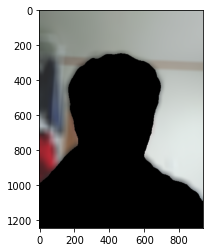

In [30]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

1. img_mask를 복사합니다.
2. mask를 반전시킵니다.
3. mask와 블러처리된 이미지를 and연산합니다.(0과 and하면 0이됨)
* 255는 11111111(2)로 표현되는데 모든 비트가 켜져있기 때문에 다른 숫자와 비트별 and 연산하면 연산 한 숫자가 그대로 남게됩니다.
ex) 11111111 & 01010101 = 01010101
* 따라서 255와 and 연산한 배경들은 원본값이 그대로 들어가게 됩니다.

### 흐린 배경의 사진과 원본 사진을 합성합시다.

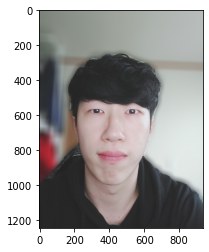

In [32]:
#img_mask_color 행렬의 값이 255(인물)일 때 원본, 아닐땐 블러이미지
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 프로젝트 : 인물 모드 문제점 찾기

## STEP 1 : 인물모드를 직접 해봅시다.
* 고양이, 자동차, 크로마키 3장의 사진을 만들어보겠습니다.

### 1. 고양이

(420, 630, 3)


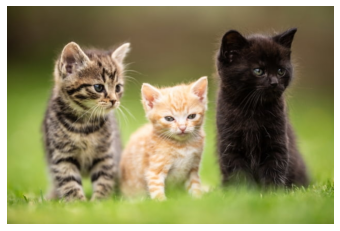

In [37]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [38]:
segment,output = model.segmentAsPascalvoc(img_path)

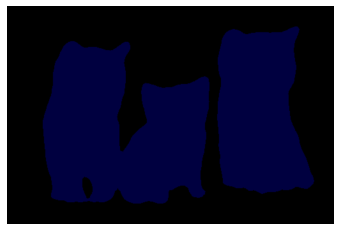

[0 8]


In [42]:
plt.imshow(output)
plt.axis('off')
plt.show()
print(segment['class_ids'])

* 고양이의 라벨은 8번입니다.

In [45]:
seg_color = np.flip(colormap[8])
seg_color

array([ 0,  0, 64])

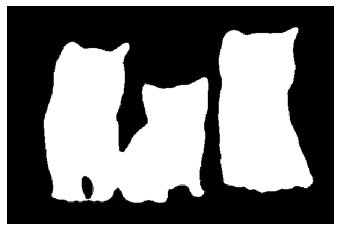

In [50]:
seg_map = np.all(output==seg_color,axis=-1)
plt.imshow(seg_map,cmap='gray')
plt.axis('off')
plt.show()

In [55]:
img_mask = seg_map.astype(np.uint8) * 255

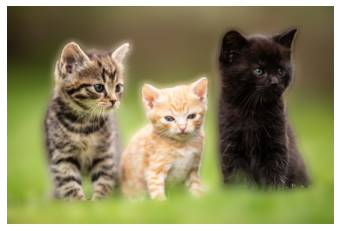

In [57]:
img_orig_blur = cv2.blur(img_orig, (20,20))
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 2. 자동차

(641, 960, 3)


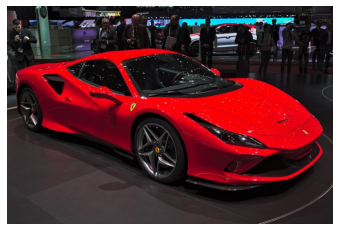

In [58]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/car.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [59]:
segment,output = model.segmentAsPascalvoc(img_path)

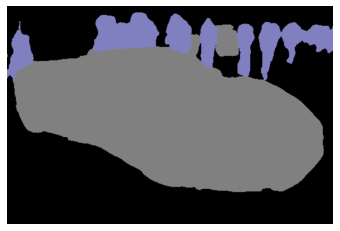

[ 0  7 15]


In [60]:
plt.imshow(output)
plt.axis('off')
plt.show()
print(segment['class_ids'])

In [61]:
seg_color = np.flip(colormap[7])
seg_color

array([128, 128, 128])

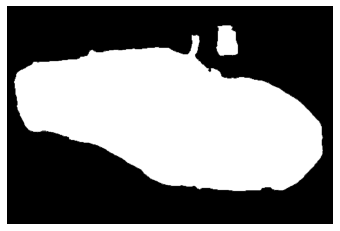

In [62]:
seg_map = np.all(output==seg_color,axis=-1)
plt.imshow(seg_map,cmap='gray')
plt.axis('off')
plt.show()

In [63]:
img_mask = seg_map.astype(np.uint8) * 255

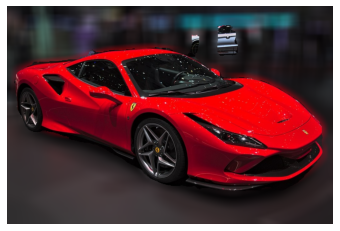

In [65]:
img_orig_blur = cv2.blur(img_orig, (40,40))
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 3. 크로마키

(1246, 935, 3)
(338, 225, 3)


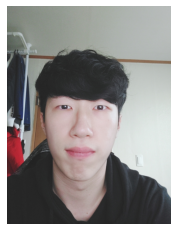

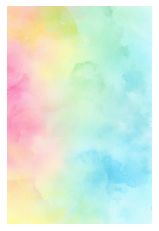

In [67]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_picture_1.jpg'  
img_orig = cv2.imread(img_path) 
# 합성에 쓰일 크로마키 이미지도 가져온다.
back_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpg'  
back_orig = cv2.imread(back_path) 
print(img_orig.shape)
print(back_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
plt.imshow(cv2.cvtColor(back_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### 두 사진의 크기를 맞춰줍니다.

(1246, 935, 3)


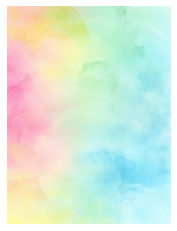

In [70]:
back_orig = cv2.resize(back_orig, dsize=(935, 1246), interpolation=cv2.INTER_AREA)
print(back_orig.shape)
plt.imshow(cv2.cvtColor(back_orig, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [71]:
segment,output = model.segmentAsPascalvoc(img_path)

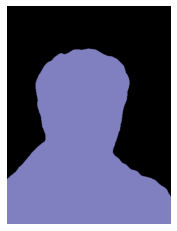

[ 0 15]


In [72]:
plt.imshow(output)
plt.axis('off')
plt.show()
print(segment['class_ids'])

In [75]:
seg_color = np.flip(colormap[15])
seg_color

array([128, 128, 192])

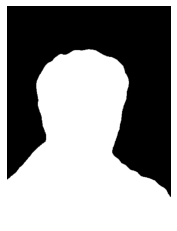

In [76]:
seg_map = np.all(output==seg_color,axis=-1)
plt.imshow(seg_map,cmap='gray')
plt.axis('off')
plt.show()

In [77]:
img_mask = seg_map.astype(np.uint8) * 255

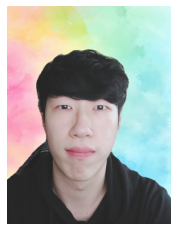

In [82]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_concat = np.where(img_mask_color==255, img_orig, back_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## STEP 2 : 사진에서 문제점 찾기
의외로 클래스 분류는 정말 잘하지만 가장 큰 문제점은 같은 클래스를 하나만 분류하지 않는다는 점입니다.  
예를 들어, 내 뒤의 옷가지를 사람으로 착각하거나 뒤에 있는 다른 사람 역시 분류된 클래스 영역에 포함시킨다는 것입니다.  
* 이전에 블러처리한 자동차 사진입니다.
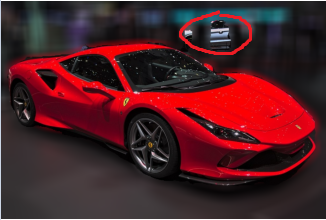
* 위 사진과 같이 한참 뒤에 있는 자동차도 영역에 포함시켜 블러처리가 되지않는 것을 볼 수 있습니다.
* 결론적으로 영역을 좀 더 정밀하게 좁힐 필요가 있습니다.

## STEP 3 : 해결 방법 제안
이전 자동차 사진에서 자동차 영역을 나타낸 이미지입니다.  

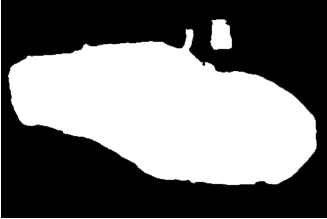
이 것으로 알 수 있는 문제점은 한참 뒤에 있는 자동차 역시 함께 영역에 포함되는 것입니다.

해결 방안이자 목표는 피사체와 상관없는 영역을 모두 없애는 것입니다.

생각해볼 점은 원하는 피사체보다 일정 거리 이상 떨어진 개체는 영역에서 제외해도 됩니다.

이를 위해 struct2Depth나 pixel4와 같이 이미지에서 깊이 정보를 알 수 있는 모델을 함께 활용해 영역을 좀 더 정밀하게 좁혀볼 수 있을 것입니다.

먼저, 피사체 역시 깊이정보가 일정하진 않을것입니다.
따라서 영역내에서 가장 깊이가 얕은 곳(가장 가까운 곳)을 기준으로 일정 범위 차이는 영역으로 포함시켜줍니다.
만약 해당 상한보다 더 멀리 있을 경우 영역에서 제외합니다.

순서대로 정리하겠습니다.
* (얕은 곳은 카메라 렌즈 기준 가장 가까운 곳입니다.)
1. 1차적으로 Semantic segmentation으로 원하는 클래스 영역을 추출합니다.
2. struct2Depth 등으로 이미지의 깊이정보를 받습니다.
3. 허용할 깊이 상한을 정합니다.
4. 깊이정보 이미지를 픽셀별로 순회하며 클래스 영역과 겹치는 곳 중 가장 얕은 깊이를 저장합니다.
5. 다시 이미지를 순회하며 (가장 얕은 곳 + 상한) < (클래스 영역과 겹치는 곳의 깊이) 일 경우 영역에서 제외합니다.

이 과정을 통해 피사체를 제외한 다른 영역을 제외할 수 있겠죠..?  
(다음에 기회가 된다면 직접 해보는것으로..)

## 회고합시다.
* Semantic segmentation 모델이 이미지 분류를 생각보다 너무 잘해서 재밌게 했습니다.
* 비트별 and 연산으로 원본 이미지에서 영역을 잘라내는건 지금까지 생각해본적도 없어서 정말 신기했습니다. 기억해두면 앞으로 유용하게 사용할 수 있을 것 같습니다.